In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import random


import keras
from matplotlib import pyplot as plt
%matplotlib inline
from keras import backend as K
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Conv2DTranspose
from keras.layers import Input,Conv1D,MaxPool1D,UpSampling1D
from keras.models import Model
from keras.optimizers import RMSprop
from keras import callbacks

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

In [3]:
df = pd.read_json(os.path.join('..', 'input', 'sample_analysis.json'))
df

,track,features,analysis
0,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.559, 'energy': 0.33, 'key':...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
1,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.874, 'energy': 0.6920000000...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
2,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.759, 'energy': 0.548, 'key'...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
3,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.861, 'energy': 0.603, 'key'...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
4,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.777, 'energy': 0.782, 'key'...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
...,...,...,...
505,"{'album': {'album_type': 'single', 'artists': ...","{'danceability': 0.554, 'energy': 0.669, 'key'...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
506,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.766, 'energy': 0.709, 'key'...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
507,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.673, 'energy': 0.886, 'key'...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."
508,"{'album': {'album_type': 'album', 'artists': [...","{'danceability': 0.592, 'energy': 0.767, 'key'...","{'meta': {'analyzer_version': '4.0.0', 'platfo..."


In [5]:
def section_to_vector(section):
    keys = ['duration', 'loudness', 'tempo', 'key', 'mode', 'time_signature']
    return list(map(abs, [section[key] for key in keys]))

arrs = [list(map(section_to_vector, sample['sections'])) for sample in df['analysis']]

(array([  3.,  27.,  89., 187.,  80.,  86.,  24.,  10.,   3.,   1.]),
 array([ 3. ,  4.8,  6.6,  8.4, 10.2, 12. , 13.8, 15.6, 17.4, 19.2, 21. ]),
 <a list of 10 Patch objects>)

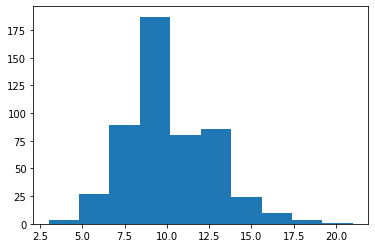

In [8]:
# sum(map(len, arrs)) / len(arrs)
plt.hist(list(map(len, arrs)))

In [9]:
# arrs = list(map(np.array, arrs))
dim2_length = len(arrs[0][0])
to_pad = 13 #max(map(len, arrs))

for i in tqdm(range(len(arrs))):
    if len(arrs[i]) >= to_pad:
        arrs[i] = arrs[i][:to_pad]
    else:
        arrs[i] += [np.zeros(dim2_length) for _ in range(to_pad - len(arrs[i]))]

100%|██████████| 510/510 [00:00<00:00, 79387.46it/s]


In [10]:
arrs = np.array(arrs) #* 1000
# arrs = arrs.reshape([*list(arrs.shape), 1])
arrs = arrs / arrs.max(axis=0)
arrs.shape

(510, 13, 6)

In [11]:
from sklearn.model_selection import train_test_split

random_state=23
test_size=0.2

X_train, X_test = train_test_split(arrs,
                                   test_size=test_size,
                                   random_state=random_state)

In [12]:
batch_size = 8
epochs = 10
input_image = Input(shape=arrs.shape[1:])

In [14]:
from datetime import datetime
dt = datetime.today() 
currentDate = ''.join([str(dt.year), str(dt.month), str(dt.day)])

bestModelName = ''.join([currentDate,'section_AutoEncoder','.h5'])

In [16]:
#encoder
#input = 428 x 600 x 3
conv1 = Conv1D(28, (5), activation='relu', padding='same', name='conv1')(input_image) #428 x 600 x 32
pool1 = MaxPool1D(pool_size=(4))(conv1) #14 x 14 x 32
conv2 = Conv1D(64, (5), activation='relu', padding='same', name='conv2')(pool1) #214 x 300 x 64
pool2 = MaxPool1D(pool_size=(4))(conv2) #7 x 7 x 64
conv3 = Conv1D(128, (5), activation='relu', padding='same', name='conv3')(pool2) #107 x 150 x 128 

#decoder
conv4 = Conv1D(128, (5), activation='relu', padding='same', name='conv4')(conv3) #107 x 150 x 128 
up1 = UpSampling1D((4))(conv4) # 14 x 14 x 128
conv5 = Conv1D(64, (5), activation='relu', padding='same', name='conv5')(up1) #214 x 300 x 64
up2 = UpSampling1D((4))(conv5) # 28 x 28 x 64
decoded = Conv1D(28, (5), activation='sigmoid', padding='same', name='conv6')(up2) #428 x 600 x 3

autoencoder = Model(input_image, decoded)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=True)

bestModelFilepath = os.path.join('.','models',bestModelName)
checkpoint = callbacks.ModelCheckpoint(bestModelFilepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

loss = keras.losses.mse
optimizer = keras.optimizers.Adam()
history = keras.callbacks.History()

autoencoder.compile(loss=loss, optimizer = optimizer)
autoencoder.summary()

ValueError: Negative dimension size caused by subtracting 4 from 3 for 'max_pooling1d_4/MaxPool' (op: 'MaxPool') with input shapes: [?,3,1,4].

In [14]:
autoencoder.fit(X_train, X_train, batch_size=batch_size,epochs=100, \
                                    callbacks=[early_stopping, checkpoint, history], verbose=True,validation_split=0.2)




Train on 326 samples, validate on 82 samples
Epoch 1/100





326/326 [==============================] - 17s 51ms/step - loss: 0.0670 - val_loss: 0.0536

Epoch 00001: val_loss improved from inf to 0.05361, saving model to ./models/2020218AutoEncoder.h5
Epoch 2/100
326/326 [==============================] - 4s 12ms/step - loss: 0.0523 - val_loss: 0.0518

Epoch 00002: val_loss improved from 0.05361 to 0.05178, saving model to ./models/2020218AutoEncoder.h5
Epoch 3/100
326/326 [==============================] - 4s 12ms/step - loss: 0.0508 - val_loss: 0.0501

Epoch 00003: val_loss improved from 0.05178 to 0.05009, saving model to ./models/2020218AutoEncoder.h5
Epoch 4/100
326/326 [==============================] - 4s 12ms/step - loss: 0.0491 - val_loss: 0.0488

Epoch 00004: val_loss improved from 0.05009 to 0.04884, saving model to ./models/2020218AutoEncoder.h5
Epoch 5/100
326/326 [==============================] - 4s 12ms/step - loss: 0.0481 - val_loss: 0.0482

Epoch 00005: val_loss i

KeyboardInterrupt: 

In [150]:
for i,j in enumerate(autoencoder.layers):
    print(i,j, j.name)

0 <keras.engine.input_layer.InputLayer object at 0x71106ac90> input_12
1 <keras.layers.convolutional.Conv1D object at 0x777631d10> conv1
2 <keras.layers.pooling.MaxPooling1D object at 0x777632210> max_pooling1d_18
3 <keras.layers.convolutional.Conv1D object at 0x777917490> conv2
4 <keras.layers.pooling.MaxPooling1D object at 0x77aa6e810> max_pooling1d_19
5 <keras.layers.convolutional.Conv1D object at 0x77efffa90> conv3
6 <keras.layers.convolutional.Conv1D object at 0x77e3fa050> conv4
7 <keras.layers.convolutional.UpSampling1D object at 0x7838ed410> up_sampling1d_17
8 <keras.layers.convolutional.Conv1D object at 0x78b80b910> conv5
9 <keras.layers.convolutional.UpSampling1D object at 0x7870e0f50> up_sampling1d_18
10 <keras.layers.convolutional.Conv1D object at 0x1bc1593210> conv6


In [151]:
get_Z_output = K.function([autoencoder.get_layer(name='conv1').input],[autoencoder.get_layer(name='conv3').output])
get_recreated_image = K.function([autoencoder.get_layer(name='conv4').input],[autoencoder.get_layer(name='conv6').output])

In [152]:
def add_shoes(shoelist):
    assert len(shoelist) > 0
    
    newShoeArray = get_Z_output([shoelist[0].reshape(1,arrs.shape[1], arrs.shape[2])])[0]
    for shoe in shoelist[1:]:
        newShoeArray += get_Z_output([shoe.reshape(1,arrs.shape[1], arrs.shape[2])])[0]
    
    return get_recreated_image([newShoeArray])[0]

add_shoes(X_train[0:2])

array([[[3.1625301e-02, 9.8970526e-01, 2.9714108e-03, ...,
         2.6577502e-02, 4.3489784e-02, 4.3766886e-02],
        [3.3635199e-02, 9.6257293e-01, 6.1200857e-03, ...,
         7.5248480e-02, 5.5717111e-02, 9.5482290e-02],
        [3.3257008e-02, 6.0541940e-01, 1.7037094e-02, ...,
         3.9539605e-02, 4.9884021e-02, 7.6803774e-02],
        ...,
        [4.1127205e-06, 8.9406967e-08, 1.7791986e-05, ...,
         1.9502640e-04, 5.8650970e-05, 3.4904480e-04],
        [1.9580126e-05, 2.6822090e-07, 4.2408705e-05, ...,
         3.0294061e-04, 1.4275312e-04, 8.1193447e-04],
        [1.9049644e-04, 2.3245811e-06, 8.3684921e-05, ...,
         6.6310167e-04, 7.3546171e-04, 2.0207465e-03]]], dtype=float32)

In [154]:
zVectorDF = pd.DataFrame(columns=['name', 'artists', 'zVector'])

for i, shoe in enumerate(df['track']):
    name = shoe['name']
    artists = '; '.join([a['name'] for a in shoe['artists']])
    zVector = get_Z_output(arrs[i:i+1])[0]
    zVectorDF.loc[i] = (name, artists, zVector.flatten().reshape(-1,1))
    print(f'Stored: {name}, shoe {i} complete')

Stored: Someone Like You, shoe 0 complete
Stored: Treasure, shoe 1 complete
Stored: Señorita, shoe 2 complete
Stored: ZEZE, shoe 3 complete
Stored: Me Niego (feat. Ozuna & Wisin), shoe 4 complete
Stored: Feel So Close - Radio Edit, shoe 5 complete
Stored: Goodbyes (feat. Young Thug), shoe 6 complete
Stored: Sunflower - Spider-Man: Into the Spider-Verse, shoe 7 complete
Stored: GDFR (feat. Sage the Gemini & Lookas), shoe 8 complete
Stored: I Feel It Coming, shoe 9 complete
Stored: I'm Yours, shoe 10 complete
Stored: Smells Like Teen Spirit, shoe 11 complete
Stored: Échame La Culpa, shoe 12 complete
Stored: Titanium (feat. Sia), shoe 13 complete
Stored: Havana, shoe 14 complete
Stored: Boy With Luv (feat. Halsey), shoe 15 complete
Stored: Trap Queen, shoe 16 complete
Stored: Thinking out Loud, shoe 17 complete
Stored: Old Town Road (feat. Billy Ray Cyrus) - Remix, shoe 18 complete
Stored: DNA., shoe 19 complete
Stored: Issues, shoe 20 complete
Stored: Body Like A Back Road, shoe 21 compl

Stored: Whatever It Takes, shoe 192 complete
Stored: Happier, shoe 193 complete
Stored: Solo (feat. Demi Lovato), shoe 194 complete
Stored: rockstar, shoe 195 complete
Stored: Soltera - Remix, shoe 196 complete
Stored: Good For You, shoe 197 complete
Stored: Hymn for the Weekend, shoe 198 complete
Stored: Pompeii, shoe 199 complete
Stored: Locked out of Heaven, shoe 200 complete
Stored: 7 Years, shoe 201 complete
Stored: Under Control (feat. Hurts), shoe 202 complete
Stored: What Lovers Do (feat. SZA), shoe 203 complete
Stored: Africa, shoe 204 complete
Stored: Psycho (feat. Ty Dolla $ign), shoe 205 complete
Stored: Last Christmas, shoe 206 complete
Stored: Believer, shoe 207 complete
Stored: Stole the Show, shoe 208 complete
Stored: Viva La Vida, shoe 209 complete
Stored: Treat You Better, shoe 210 complete
Stored: Can't Feel My Face, shoe 211 complete
Stored: Happier, shoe 212 complete
Stored: PILLOWTALK, shoe 213 complete
Stored: Bodak Yellow, shoe 214 complete
Stored: Drunk in Love

Stored: Yeah! (feat. Lil Jon & Ludacris), shoe 372 complete
Stored: Escápate Conmigo (feat. Ozuna), shoe 373 complete
Stored: Chasing Cars, shoe 374 complete
Stored: I Took A Pill In Ibiza - Seeb Remix, shoe 375 complete
Stored: Bohemian Rhapsody - 2011 Mix, shoe 376 complete
Stored: LOVE. FEAT. ZACARI., shoe 377 complete
Stored: FRIENDS, shoe 378 complete
Stored: Wannabe, shoe 379 complete
Stored: Wow., shoe 380 complete
Stored: Never Be the Same, shoe 381 complete
Stored: Don't, shoe 382 complete
Stored: Problem, shoe 383 complete
Stored: Panda, shoe 384 complete
Stored: Let It Go, shoe 385 complete
Stored: Locked Away, shoe 386 complete
Stored: Be Alright, shoe 387 complete
Stored: Riptide, shoe 388 complete
Stored: We Will Rock You - Remastered, shoe 389 complete
Stored: Feel It Still, shoe 390 complete
Stored: In My Mind, shoe 391 complete
Stored: Jumpman, shoe 392 complete
Stored: Eye of the Tiger, shoe 393 complete
Stored: Bitch Better Have My Money, shoe 394 complete
Stored: Wa

In [155]:
from scipy import spatial

def create_cosine_similarity(shoe1, shoe2):
    result = 1 - spatial.distance.cosine(shoe1, shoe2)
    return result

In [181]:
def get_similar(ind):
    print('Songs most similar to', zVectorDF['name'][ind], 'by', zVectorDF['artists'][ind])
    ex = get_Z_output([arrs[ind:ind+1,:]])[0].flatten().reshape(-1,1)
    ll = []
    for i in zVectorDF.zVector:
        ll.append(create_cosine_similarity(i, ex))
    
    zVectorDF['similarity (cosine)'] = ll
    ind = pd.concat([
        zVectorDF.sort_values(by='similarity (cosine)', ascending=False).head()[['name', 'artists', 'similarity (cosine)']],
        zVectorDF.sort_values(by='similarity (cosine)', ascending=False).head()[['name', 'artists', 'similarity (cosine)']]])
    return ind

get_similar(10)

Songs most similar to I'm Yours by Jason Mraz


,name,artists,similarity (cosine)
10,I'm Yours,Jason Mraz,1.000000
476,Love Yourself,Justin Bieber,0.833147
364,"Feels (feat. Pharrell Williams, Katy Perry & B...",Calvin Harris; Pharrell Williams; Katy Perry; ...,0.825484
262,Work,Rihanna; Drake,0.824314
282,Shape of You,Ed Sheeran,0.821271


In [174]:
# zVectorDF.loc[zVectorDF['artists'] == 'Travis Scott']
zVectorDF = zVectorDF.drop(['cosineScore'], axis=1)